In [15]:
import os, re, sys, json
import numpy as np, pandas as pd
import _config
reload (_config)
from _config import SHE3202_FQ_FILES, EXP_DESIGN_2901, OLIGO_LIBRARY, SHE3202_DIR, A_BC_OLIGOS_OUT, POSITIVE_CONTROLS_FILE




In [ ]:
prnt OLI

In [126]:


from _config import DATA_DIR, OUT_PLACE, N_SPLITS, QSUBS_DIR, EXP_NAMES
TX_INP_DIR = os.path.join(OUT_PLACE, "c0_bin_transcript_umis")
OLIGO_INP_DIR = os.path.join(OUT_PLACE, "b1_demultiplex_oligos")


#load oligo library from experimental design
oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
positive_controls = pd.read_csv(POSITIVE_CONTROLS_FILE)


split = "1"
inp_dir = "../out/b1_demultiplex_oligos/"
merged_results = pd.DataFrame()
tx_discovery_rates = []
oligo_mapping_success_rates = []
total_txs = 0
total_oligos = 0




#load barcode-matched umis from dictionary reads
for oligo_file in os.listdir(OLIGO_INP_DIR):
    #file_format = "../out/b1_demultiplex_oligos/20190320-100XSTARRseq-Nextera-PE_HKNM2AFXY_S1_L001_3.json"
    if not ("_"+split+".json" in oligo_file):
        continue
    

    
    print(oligo_file)
    
    a_output2 = pd.read_csv(os.path.join(inp_dir,oligo_file))
    a_output2 = a_output2.rename({"umi":"bc"}, axis = "columns")
    a_output_15 = a_output2.loc[a_output2.bc.str.len() == 15]
    total_oligos+= len(a_output2)
    
    for k, ogroup in a_output_15.groupby(a_output_15.bc.str.slice(0,3)):
        for exp in EXP_NAMES:
    
            tx_file = os.path.join(TX_INP_PATH,"{}_{}.csv".format(exp,k))
            tx_subdict_df = pd.read_csv(tx_file)
            tx_subdict_df["exp"] = exp
            total_txs += len(tx_subdict_df)
            merged_results = merged_results.append(pd.merge(tx_subdict_df,ogroup,on="bc"))
                                      

            oligo_mapping_success_rates.append(float(len(merged_results)) / len(ogroup))
            tx_discovery_rates.append(float(len(merged_results)) / len(tx_subdict_df))
        
            break
        break
    merged_results.to_csv(os.path.join(OUT_DIR,OLIGO_FILE))
    break

SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L002_1.json


In [14]:

OLIGO_INP_DIR = os.path.join(OUT_PLACE, "c0_bin_transcript_umis")
TX_INP_DIR = os.path.join(OUT_PLACE, "b1_demultiplex_transcripts")


#load oligo library from experimental design
oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
positive_controls = pd.read_csv(POSITIVE_CONTROLS_FILE)


split = "1"
inp_dir = "../out/b1_demultiplex_oligos/"

#load barcode-matched umis from dictionary reads
for oligo_file in os.listdir(OLIGO_INP_DIR):
    #file_format = "../out/b1_demultiplex_oligos/20190320-100XSTARRseq-Nextera-PE_HKNM2AFXY_S1_L001_3.json"
    if !("_"+split+".json" in oligo_file):
        continue
    
    
    a_output2 = pd.read_csv(os.path.join(inp_dir,oligo_file))
    a_output_15 = a_output2.loc[a_output2.bc.str.len() == 15]
    
    for k, ogroup in a_output_15.groupby(a_output_15.bc.str.slice(0,3)):
        for exp in EXP_NAMES:

            tx_file = os.path.join(TX_INP_PATH,"{}_{}.csv".format(exp,k))
            tx_subdict_df = pd.read_csv(tx_file)
            tx_subdict_df["exp"] = exp

            break
        break
    break

        
    #recover the list of bc_umi edges from the transcription data
    #this takes a long time
    print "loading transcripts"
    #with open("../data/all_bcs2umis.json") as f:
    #    umi_bcs_json = json.load(f)

    print "getting oligos"
    unique_oligos = a_output.oligo.unique()   
    print "computing keys"
    print "done with keys"
    #this command takes a very long time...
    unique_bcs =  [k for k,g in a_output.groupby("bc",) if len(g) == 1]
    unique_bcs_set = set(unique_bcs)
    unique_bc_oligos = a_output.loc[a_output.bc.isin(unique_bcs_set) ]



In [ ]:
a_

In [68]:
a_output.bc.apply(lambda x: len(x)).value_counts()

15    408548
14      2342
13       285
12        86
11        42
9         29
10        23
7         14
8         13
6          6
4          4
5          3
3          2
2          1
1          1
Name: bc, dtype: int64

In [ ]:
a_output.bc.str.len

In [73]:
a_output.bc.str.len

<bound method StringMethods.len of <pandas.core.strings.StringMethods object at 0x7fa950cd7450>>

In [75]:
reload(_config)


from _config import EXP_NAMES
TX_INP_PATH = "../out/c0_bin_transcript_umis/"

a_output_15 = a_output.loc[a_output.bc.str.len() == 15]
for k, ogroup in a_output_15.groupby(a_output_15.bc.str.slice(0,3)):
    for exp in EXP_NAMES:
        
        tx_file = os.path.join(TX_INP_PATH,"{}_{}.csv".format(exp,k))
        tx_subdict_df = pd.read_csv(tx_file)
        tx_subdict_df["exp"] = exp
        
        break

In [ ]:
tx_subdict_df

In [22]:
a_output= a_output.rename({"umi":"bc"}, axis = "columns")

In [24]:

#this command takes a very long time...
unique_bcs =  [k for k,g in a_output.groupby("bc",) if len(g) == 1]
unique_bcs_set = set(unique_bcs)
unique_bc_oligos = a_output.loc[a_output.bc.isin(unique_bcs_set) ]

In [45]:

#THIS FUNCTION GETS TRANSCRIPTS!!!!
fa_found = []
def wfun(arg,dirname,fnames):
    for f in fnames:
        if f[-2:]=="fa":
            fa_found.append(os.path.join(dirname,f))
            
walkeroo = os.walk("../out/b0_demultiplex_transcripts/",wfun, None)
  


['../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_0.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R2_0.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_3.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R2_3.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_11.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R2_11.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_2.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R2_2.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_14.fa',
 '../out/b0_demultiplex_transcripts/Undetermined_AH3W5GBGX9_S0_L001/HCT116_WT_BR1/R1_8.fa']

In [ ]:
for o in walkeroo:
    print(o)

In [25]:
sxs = 0
fails = 0

all_shared_bcs = set()
exps = [e.strip() for e in """DLD1_WT_BR2
DLD1_WT_BR1
HCT116_WT_BR2
HCT116_WT_BR1
U2OS_WT_BR1
other
U2OS_WT_BR2
HCT116_Gemcitabine2uM_BR2
HCT116_Gemcitabine2uM_BR1""".splitlines()]
oligo_info = pd.DataFrame(index=[(exp,o) for o in unique_oligos for exp in exps])

oligos = unique_bc_oligos.groupby("oligo")
for exp in exps:
    print exp
    print "loading"
    with open("../data/all_{}_bcs2umis.json".format(exp)) as f:
        vals = json.load(f)
    

    
    print "done loading"
    cnt = 0 
    if exp =="other": continue
    for o, rows in oligos:
        obcs_set = set(rows.bc)
        shared_bcs = [b for b in obcs_set if b in vals]
        all_shared_bcs.update(shared_bcs)
        count_transcripts = len(set([t for b in shared_bcs for t in vals[b]]))
        oligo_info.at[(exp,o),"n_transcripts"] = count_transcripts
        oligo_info.at[(exp,o),"n_total_bcs"] = len(obcs_set)
        oligo_info.at[(exp,o),"n_observed_bcs"] = len(shared_bcs)
        
        cnt+= 1
        if len(shared_bcs) > 0:
            oligo_info.at[(exp,o),"argmax_transcriptions_per_bcs"] = sorted(list(shared_bcs),key = lambda x: len(set(vals[x])))[-1]
            oligo_info.at[(exp,o),"max_transcriptions_per_bcs"] = len(set(vals[sorted(list(shared_bcs),key = lambda x: len(set(vals[x])))[-1]]))
            #sxs +=1
        else:
            pass
                #fails+=1
        #print fails, sxs
        
oligo_info["oligo"] = oligo_info.index.map(lambda x:x[1])
oligo_info["exp"] = oligo_info.index.map(lambda x:x[0])
oligo_info.to_csv("../data/0304_oligo_statistics.csv")


DLD1_WT_BR2
loading
done loading
DLD1_WT_BR1
loading
done loading
HCT116_WT_BR2
loading
done loading
HCT116_WT_BR1
loading
done loading
U2OS_WT_BR1
loading
done loading
other
loading
done loading
U2OS_WT_BR2
loading
done loading
HCT116_Gemcitabine2uM_BR2
loading
done loading
HCT116_Gemcitabine2uM_BR1
loading
done loading


In [253]:
split = 2
MERGED_INP_DIR = os.path.join(OUT_PLACE,"c1_merge_tx_oligos")
INP_FILE = os.path.join(MERGED_INP_DIR,"merged_{}_{}.csv".format(28,split))
merged_results = pd.read_csv(INP_FILE)
oligo_info = pd.DataFrame(index=list(set(merged_results.apply(lambda x:(x.exp, x.oligo),axis=1))))
#oligo_info.at[(exp,o),"n_transcripts"] = count_transcripts
oligo_info["n_transcripts"] = merged_results.groupby(["exp","oligo"]).apply(lambda x:x.umi.nunique())
oligo_info["n_observed_bcs"] = merged_results.groupby(["exp","oligo"]).apply(lambda x:x.bc.nunique())
oligo_info["oligo"] = oligo_info.index.map(lambda x:x[1])
oligo_info["exp"] = oligo_info.index.map(lambda x:x[0])
oligo_info.to_csv("../data/0612_oligo_statistics.csv")

# PLOTS #

In [254]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt


In [255]:
oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
oligo_info2 = oligo_info.copy().join(oligos_lib, on ="oligo").dropna()

In [256]:
positive_controls
positive_control_rows = oligo_info2.loc[oligo_info2.RefSeqID.isin(positive_controls.Name)]

Q: Given the list of positive control oligos which are known to be expressed, do we see these in the transcript data? Are they transcribed abundantly?

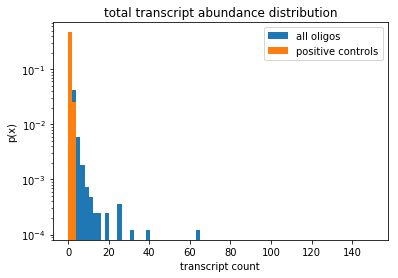

In [257]:

f, subs = plt.subplots(1,1)

s = subs
s.semilogy()
positive_control_info = oligo_info.loc[oligo_info.oligo.isin(positive_control_rows.id)]
bins = np.linspace(0,150,75)
s.hist(oligo_info2.n_transcripts, density=True, bins = bins, label="all oligos")
s.hist(positive_control_rows.n_transcripts, density=True, bins = bins, label="positive controls")
s.set_title("total transcript abundance distribution")
s.set_xlabel("transcript count")
s.set_ylabel("p(x)")
s.legend()



pass

In [258]:
#test = oligo_info2
candid_regex = re.compile("candid_(\d+)")
neg_regex = re.compile("Neg_(\d+)")

mutant_regex = re.compile("mut(\d+)$")
oligo_info2["locus_ids"] = oligo_info2.RefSeqID.apply(lambda x: int(candid_regex.search(x).groups()[0]) if candid_regex.search(x) else neg_regex.search(x).groups()[0] )
oligo_info2["mutant_num"] = oligo_info2.RefSeqID.apply(lambda x: int(mutant_regex.search(x).groups()[0]) if mutant_regex.search(x) else 0 )
oligo_info2["is_cand"] = oligo_info2.RefSeqID.apply(lambda x: True if candid_regex.search(x) else False )
oligo_info2["is_neg"] = oligo_info2.RefSeqID.apply(lambda x: True if neg_regex.search(x) else False )


In [259]:
oligo_info2.mutant_num.unique()

array([0, 3, 2, 4, 1, 5])

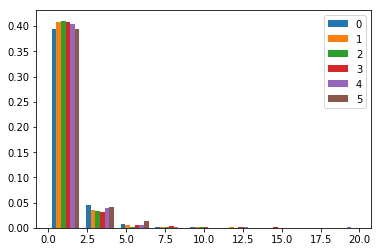

In [260]:
transcript_groups = oligo_info2.groupby("mutant_num").n_transcripts

h = plt.hist([e[1].values for e in transcript_groups], bins = np.linspace(0,20,10),density=True,label = [k for k,v in transcript_groups])
plt.legend()
#plt.hist([list(v for v in grp) for grp in transcript_groups], bins = np.linspace(0,20), density = True)
#plt.legend()

#TABLE 1#
Enrichment counts for each oligo in each cell conditioned, in a table

In [261]:
enrichments = pd.DataFrame()
# enrichments_vs_all = pd.DataFrame()
# observations_vs_all = pd.DataFrame()
#enrichments.index =pd.Series( oligo_info2.oligo.unique())
for k,g in oligo_info2.groupby("exp"):
    #print  g.apply(lambda x:x.n_transcripts / x.n_observed_bcs)
    enrichments[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_observed_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #enrichments_vs_all[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_total_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #observations_vs_all[k] = pd.Series(g.apply(lambda x:x.n_observed_bcs / x.n_total_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #enrichments[k+"_vs_bcs"] = g.apply(lambda x:x.n_transcripts / x.n_observed_bcs, axis = 1)


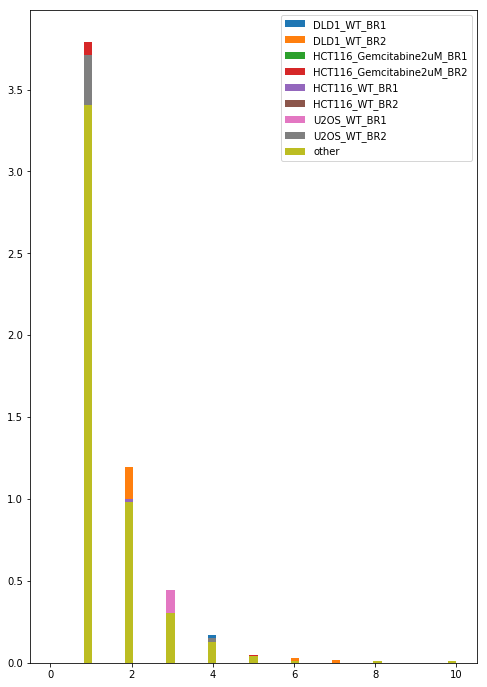

In [267]:
bins = np.linspace(0,10,50)
f,ax = plt.subplots(1,1)

f.set_size_inches(8,12)
plt.sca(ax)
for k in enrichments.columns:
    ax.hist(enrichments[k].dropna(), density = True, bins = bins)
plt.legend()